# Strip to slot waveguide converters

A strip waveguide is the most common integrated photonic waveguide that consists of a higher refractive index medium surrounded by a lower refractive index medium. The strip waveguide supports transverse electric (TE) and transverse magnetic (TM) modes of light propagation. On the other hand, a slot waveguide is a type of optical waveguide that consists of two strips of higher refractive index medium separated by a slot of lower refractive index medium. The slot waveguide supports only TE mode of light propagation. The unique property of the slot waveguide is the ability to confine light in the low refractive index region, which can be used to enhance light-matter interaction.

A strip-to-slot waveguide converter is a device that is used to convert the mode of light propagation from a strip waveguide mode to a slot waveguide mode. The converter is designed in such a way that the conversion is efficient and with minimal loss of light. The strip-to-slot waveguide converter is an important component in integrated photonic circuits, enabling the use of different waveguide configurations for different functionalities within the same circuit.

In this notebook, we demonstrate three different converter designs and compare their pros and cons. The strip waveguide has a width of 400 nm. The slot waveguide has a width of 620 nm with a 100 nm slot width. Both waveguides are fabricated on 250 nm silicon on insulator with oxide top cladding.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
import tidy3d.web as web
from tidy3d.plugins import waveguide

## Visualizing the Strip and Slot Modes

Before any simulation, we can use the [waveguide plugin](https://www.flexcompute.com/tidy3d/examples/notebooks/WaveguidePluginDemonstration/) to study the strip and slot waveguide modes.

Define the simulation wavelength and frequency ranges.

In [2]:
lda0 = 1.55  # central wavelength
ldas = np.linspace(1.5, 1.6, 101)  # wavelength range of interest
freq0 = td.C_0 / lda0  # central frequency
freqs = td.C_0 / ldas  # frequency range of interest
fwidth = 0.5 * (np.max(freqs) - np.min(freqs))  # frequency width of the source

Define the geometric parameters of the waveguides.

In [3]:
h_si = 0.25  # thickness of the silicon layer
w_strip = 0.4  # width of the strip waveguide
w_slot = 0.62  # width of the slot waveguide
g = 0.1  # width of the slot

Define material properties. 

In [4]:
n_si = 3.47  # silicon refractive index
si = td.Medium(permittivity=n_si**2)

n_sio2 = 1.44  # silicon oxide refractive index
sio2 = td.Medium(permittivity=n_sio2**2)

We use the [waveguide plugin](https://www.flexcompute.com/tidy3d/examples/notebooks/WaveguidePluginDemonstration/) to visualize the strip mode profile. 

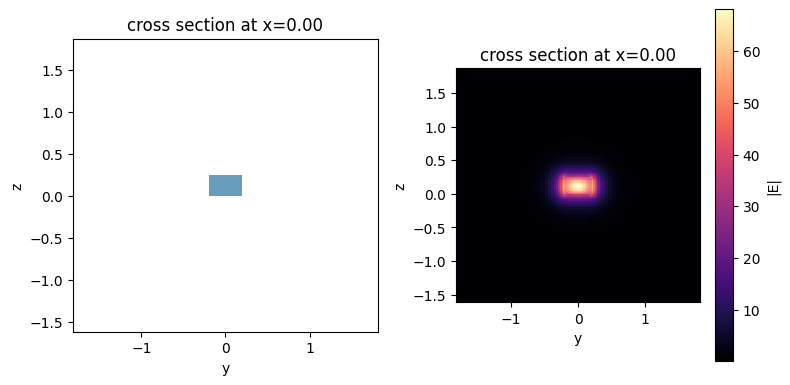

In [5]:
strip = waveguide.RectangularDielectric(
    wavelength=lda0,
    core_width=w_strip,
    core_thickness=h_si,
    core_medium=si,
    clad_medium=sio2,
    mode_spec=td.ModeSpec(num_modes=1),
)

fig, ax = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)

strip.plot_structures(x=0, ax=ax[0])

strip.plot_field("E", val="abs", ax=ax[1], robust=False)

Similarly, we visualize the slot mode profile. As expected, the mode concentrates inside the slot.

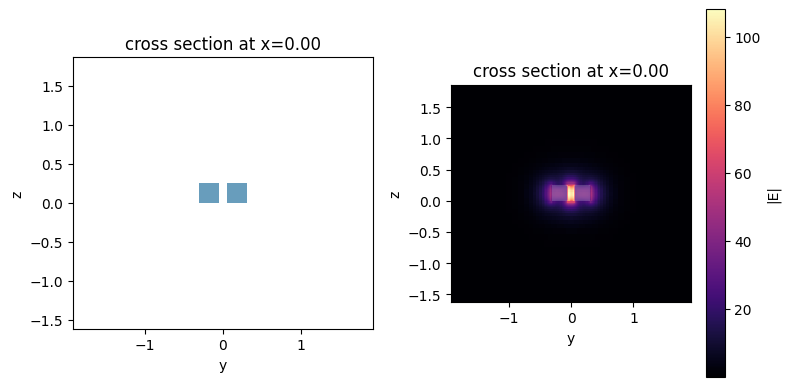

In [6]:
slot = waveguide.RectangularDielectric(
    wavelength=lda0,
    core_width=((w_slot - g) / 2, (w_slot - g) / 2),
    core_thickness=h_si,
    core_medium=si,
    clad_medium=sio2,
    gap=g,
    mode_spec=td.ModeSpec(num_modes=1),
)

fig, ax = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)

slot.plot_structures(x=0, ax=ax[0])

# We use 'robust=False' because we're interested in the large values at the slot
slot.plot_field("E", val="abs", ax=ax[1], robust=False)

Besides visualizing the mode profiles, the [waveguide plugin](https://www.flexcompute.com/tidy3d/examples/notebooks/WaveguidePluginDemonstration/) also provides many other functionalities such as calculating the effective indices and mode volume to help with extensive mode analysis. For detail, please refer to the [waveguide plugin tutorial](https://www.flexcompute.com/tidy3d/examples/notebooks/WaveguidePluginDemonstration/).

## Design 1

The first converter design is based on symmetric multimode interference as introduced in `Qingzhong Deng, Lu Liu, Xinbai Li, and Zhiping Zhou, "Strip-slot waveguide mode converter based on symmetric multimode interference," Opt. Lett. 39, 5665-5668 (2014)`[DOI: 10.1364/OL.39.005665](https://doi.org/10.1364/OL.39.005665). In this design, the footprint of the converter is compact (~ 6 $\mu m$) and it does not contain pointy parts that are hard to fabricate. The achievable coupling efficiency is above 95% in the entire C band.

<img src="img/strip_to_slot_1.png" width="400" alt="Schematic of the first strip to slot converter design">

Define geometric parameters of the device.

In [7]:
L_mmi = 1.38  # length of the MMI section
W_mmi = 1.24  # width of the MMI section
L = 6  # length of the taper
buffer = 5  # buffer spacing before and after the converter

The converter designs in this notebook do not contain bending parts. Therefore, the easiest way to define the geometries is by using [PolySlabs](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.PolySlab.html). The coordinates of the vertices can be easily calculated using the geometric parameters defined above.

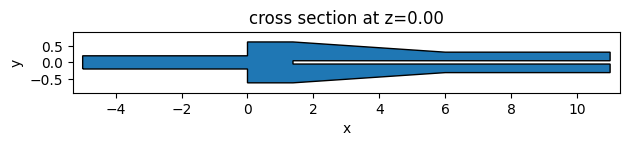

In [8]:
# define the poly slab vertices
vertices = [
    (-buffer, w_strip / 2),
    (0, w_strip / 2),
    (0, W_mmi / 2),
    (L_mmi, W_mmi / 2),
    (L, w_slot / 2),
    (L + buffer, w_slot / 2),
    (L + buffer, g / 2),
    (L_mmi, g / 2),
    (L_mmi, -g / 2),
    (L + buffer, -g / 2),
    (L + buffer, -w_slot / 2),
    (L, -w_slot / 2),
    (L_mmi, -W_mmi / 2),
    (0, -W_mmi / 2),
    (0, -w_strip / 2),
    (-buffer, -w_strip / 2),
]

# define the converter structure
converter = td.Structure(
    geometry=td.PolySlab(vertices=vertices, axis=2, slab_bounds=(-h_si / 2, h_si / 2)), medium=si
)

# plot the structure for visualization
converter.plot(z=0)
plt.show()

We will use a [ModeSource](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.ModeSource.html) to excite the strip waveguide using the fundamental TE mode. Note that we use `num_freqs=7` Chebyshev nodes to approximate mode frequency dependency in `[freq0 - 1.5 * fwidth, freq0 + 1.5 * fwidth]` for an accurate broadband simulation.

A [ModeMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.ModeMonitor.html) is placed at the slot waveguide to measure the coupling efficiency. A [FieldMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.FieldMonitor.html) is added to the $xy$ plane to visualize the field distribution.

In [9]:
# add a mode source to launch the TE0 mode at the strip waveguide before the converter
mode_spec = td.ModeSpec(num_modes=1, target_neff=n_si)
mode_source = td.ModeSource(
    center=(-lda0, 0, 0),
    size=(0, 4 * w_strip, 6 * h_si),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="+",
    mode_spec=mode_spec,
    mode_index=0,
    num_freqs=7,
)

# add a mode monitor to measure transmission at the slot waveguide after the converter
mode_monitor = td.ModeMonitor(
    center=(L + lda0, 0, 0),
    size=(0, 4 * w_strip, 6 * h_si),
    freqs=freqs,
    mode_spec=mode_spec,
    name="mode",
)

# add a field monitor to visualize field distribution at z=0
field_monitor = td.FieldMonitor(
    center=(0, 0, 0), size=(td.inf, td.inf, 0), freqs=[freq0], name="field"
)

Set up the [Simulation](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Simulation.html) with the previously defined [Structure](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Structure.html), source, and monitors. All boundaries are set to PML to mimic infinite open space. Since the top and bottom claddings are silicon oxide, we will set the medium of the background to silicon oxide. Due to the symmetry of the device and the modes, we utilize `symmetry=(0,-1,1)` to reduce the computational cost to a quarter. For such a small simulation domain, we can afford to use a very fine grid.

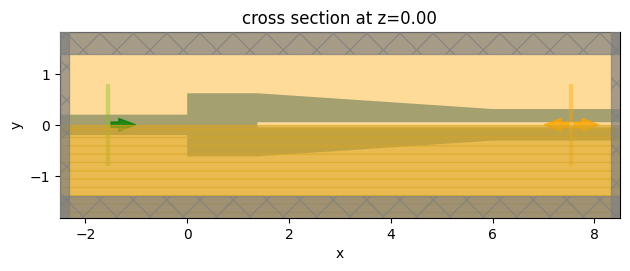

In [10]:
Lx = L + 3 * lda0  # simulation domain size in x direction
Ly = W_mmi + lda0  # simulation domain size in y direction
Lz = 10 * h_si  # simulation domain size in z direction
sim_size = (Lx, Ly, Lz)

run_time = 1e-12  # simulation run time

# construct simulation
sim_1 = td.Simulation(
    center=(L / 2, 0, 0),
    size=sim_size,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=30, wavelength=lda0),
    structures=[converter],
    sources=[mode_source],
    monitors=[mode_monitor, field_monitor],
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
    medium=sio2,
    symmetry=(0, -1, 1),
)

# plot the simulation
sim_1.plot(z=0)
plt.show()

Submit the simulation to the server to run.

In [11]:
sim_data_1 = web.run(
    simulation=sim_1, task_name="strip_to_slot_converter_1", path="data/simulation_data.hdf5"
)

13:03:12 Eastern Standard Time Created task 'strip_to_slot_converter_1' with    
                               task_id                                          
                               'fdve-6eb94abb-c94e-4e96-88f8-98df44ec0f09' and  
                               task_type 'FDTD'.

                               View task using web UI at                        
                               ]8;id=439931;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6eb94abb-c94e-4e96-88f8-98df44ec0f09\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=173742;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6eb94abb-c94e-4e96-88f8-98df44ec0f09\taskId]8;;\
                               ]8;id=439931;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6eb94abb-c94e-4e96-88f8-98df44ec0f09\=]8;;\]8;id=732163;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6eb94abb-c94e-4e96-88f8-98df44ec0f09\fdve]8;;\]8;id=439931;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6eb94abb-c94e-4e96-88f8-98df44ec0f09\-6eb94abb-c94e-4e96-88f8-98df44ec0f09']8;;\.

Output()

13:03:13 Eastern Standard Time status = queued

Output()

13:03:25 Eastern Standard Time status = preprocess

13:03:28 Eastern Standard Time Maximum FlexCredit cost: 0.055. Use              
                               'web.real_cost(task_id)' to get the billed       
                               FlexCredit cost after a simulation run.

                               starting up solver

                               running solver

                               To cancel the simulation, use                    
                               'web.abort(task_id)' or 'web.delete(task_id)' or 
                               abort/delete the task in the web UI. Terminating 
                               the Python script will not stop the job running  
                               on the cloud.

Output()

13:03:52 Eastern Standard Time early shutoff detected at 36%, exiting.

                               status = postprocess

Output()

13:03:55 Eastern Standard Time status = success

                               View simulation result at                        
                               ]8;id=872942;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6eb94abb-c94e-4e96-88f8-98df44ec0f09\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=344803;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6eb94abb-c94e-4e96-88f8-98df44ec0f09\taskId]8;;\
                               ]8;id=872942;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6eb94abb-c94e-4e96-88f8-98df44ec0f09\=]8;;\]8;id=126945;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6eb94abb-c94e-4e96-88f8-98df44ec0f09\fdve]8;;\]8;id=872942;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6eb94abb-c94e-4e96-88f8-98df44ec0f09\-6eb94abb-c94e-4e96-88f8-98df44ec0f09']8;;\.

Output()

13:03:57 Eastern Standard Time loading simulation from data/simulation_data.hdf5

We define two postprocessing functions `plot_convertion_efficiency` and `plot_field` to plot the coupling efficiency of the converter as well as the field distributions.

For this design, we see a coupling efficiency above 95%.

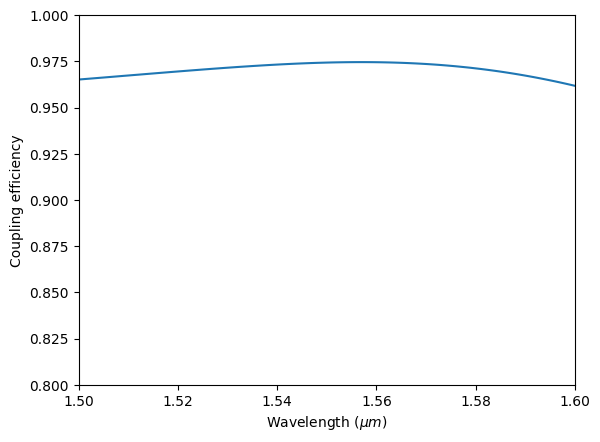

In [12]:
def plot_convertion_efficiency(sim_data):
    # extract the convertion efficiency from the mode monitor
    amp = sim_data["mode"].amps.sel(mode_index=0, direction="+")
    T = np.abs(amp) ** 2

    # plot the coupling efficiency
    plt.plot(ldas, T)
    plt.xlim(1.5, 1.6)
    plt.ylim(0.8, 1)
    plt.xlabel("Wavelength ($\mu m$)")
    plt.ylabel("Coupling efficiency")
    plt.show()


plot_convertion_efficiency(sim_data_1)

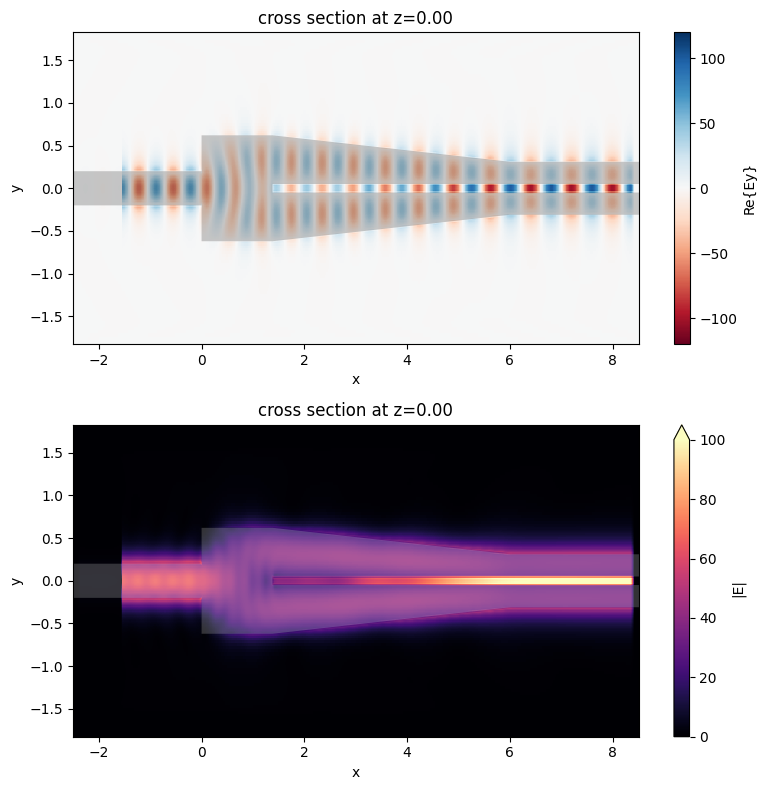

In [13]:
def plot_field(sim_data):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), tight_layout=True)

    sim_data.plot_field(
        field_monitor_name="field",
        field_name="Ey",
        val="real",
        f=freq0,
        vmin=-120,
        vmax=120,
        ax=ax1,
    )
    ax1.set_aspect("auto")

    sim_data.plot_field(
        field_monitor_name="field", field_name="E", val="abs", f=freq0, vmin=0, vmax=100, ax=ax2
    )
    ax2.set_aspect("auto")
    plt.show()


plot_field(sim_data_1)

## Design 2

The second design of the strip to slot waveguide converter is based on symmetry linear tapers as introduced in `Zhechao Wang, Ning Zhu, Yongbo Tang, Lech Wosinski, Daoxin Dai, and Sailing He, "Ultracompact low-loss coupler between strip and slot waveguides," Opt. Lett. 34, 1498-1500 (2009)`[DOI: 10.1364/OL.34.001498](https://doi.org/10.1364/OL.34.001498). This design is compact (~ 8$\mu m$) and can achieve nearly 100% coupling efficiency. However, it contains smaller features associated with the tips of the tapers. In practice, fabrication tolerance can degrade the device performance. 

To define the structures of this converter, again we use a similar approach by defining the vertices and constructing [PolySlabs](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.PolySlab.html). This device contains three separate structures, which we name `strip_taper`, `slot_top`, and `slot_bottom`.

<img src="img/strip_to_slot_2.png" width="400" alt="Schematic of the second strip to slot converter design">

In [14]:
L_taper = 8  # length of the taper
d = 0.06  # distance between the taper end and the strip

vertices = [
    (-buffer, w_strip / 2),
    (0, w_strip / 2),
    (L_taper, 0),
    (0, -w_strip / 2),
    (-buffer, -w_strip / 2),
]

strip_taper = td.Structure(
    geometry=td.PolySlab(vertices=vertices, axis=2, slab_bounds=(-h_si / 2, h_si / 2)), medium=si
)

vertices = [
    (0, w_strip / 2 + d),
    (L_taper, w_slot / 2),
    (L_taper + buffer, w_slot / 2),
    (L_taper + buffer, g / 2),
    (L_taper, g / 2),
]

slot_top = td.Structure(
    geometry=td.PolySlab(vertices=vertices, axis=2, slab_bounds=(-h_si / 2, h_si / 2)), medium=si
)

vertices = [
    (0, -w_strip / 2 - d),
    (L_taper, -w_slot / 2),
    (L_taper + buffer, -w_slot / 2),
    (L_taper + buffer, -g / 2),
    (L_taper, -g / 2),
]

slot_bottom = td.Structure(
    geometry=td.PolySlab(vertices=vertices, axis=2, slab_bounds=(-h_si / 2, h_si / 2)), medium=si
)

The overall setup of this simulation is very similar to the previous one so we can reuse many previously defined objects. However, we need to adjust the [ModeMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.ModeMonitor.html) position, which can be done conveniently by copying the previous [ModeMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.ModeMonitor.html) and only updating its center position.

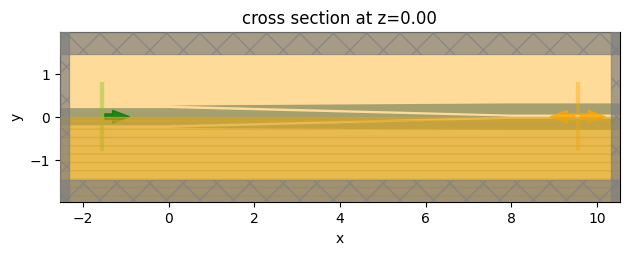

In [15]:
# add a mode monitor to measure transmission at the output waveguide
mode_monitor = mode_monitor.copy(update={"center": (L_taper + lda0, 0, 0)})

Lx = L_taper + 3 * lda0  # simulation domain size in x direction
Ly = w_slot + 1.5 * lda0  # simulation domain size in y direction
sim_size = (Lx, Ly, Lz)

# construct simulation
sim_2 = td.Simulation(
    center=(L_taper / 2, 0, 0),
    size=sim_size,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=25, wavelength=lda0),
    structures=[strip_taper, slot_top, slot_bottom],
    sources=[mode_source],
    monitors=[mode_monitor, field_monitor],
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
    medium=sio2,
    symmetry=(0, -1, 1),
)

sim_2.plot(z=0)
plt.show()

Submit the simulation to the server to run.

In [16]:
sim_data_2 = web.run(
    simulation=sim_2, task_name="strip_to_slot_converter_2", path="data/simulation_data.hdf5"
)

13:03:58 Eastern Standard Time Created task 'strip_to_slot_converter_2' with    
                               task_id                                          
                               'fdve-8cef99a1-cfdd-4002-b0c8-182677e2c50c' and  
                               task_type 'FDTD'.

                               View task using web UI at                        
                               ]8;id=48735;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8cef99a1-cfdd-4002-b0c8-182677e2c50c\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=534396;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8cef99a1-cfdd-4002-b0c8-182677e2c50c\taskId]8;;\
                               ]8;id=48735;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8cef99a1-cfdd-4002-b0c8-182677e2c50c\=]8;;\]8;id=517836;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8cef99a1-cfdd-4002-b0c8-182677e2c50c\fdve]8;;\]8;id=48735;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8cef99a1-cfdd-4002-b0c8-182677e2c50c\-8cef99a1-cfdd-4002-b0c8-182677e2c50c']8;;\.

Output()

13:04:00 Eastern Standard Time status = queued

Output()

13:04:05 Eastern Standard Time status = preprocess

13:04:09 Eastern Standard Time Maximum FlexCredit cost: 0.038. Use              
                               'web.real_cost(task_id)' to get the billed       
                               FlexCredit cost after a simulation run.

                               starting up solver

                               running solver

                               To cancel the simulation, use                    
                               'web.abort(task_id)' or 'web.delete(task_id)' or 
                               abort/delete the task in the web UI. Terminating 
                               the Python script will not stop the job running  
                               on the cloud.

Output()

13:04:32 Eastern Standard Time early shutoff detected at 36%, exiting.

                               status = postprocess

Output()

13:04:35 Eastern Standard Time status = success

                               View simulation result at                        
                               ]8;id=713009;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8cef99a1-cfdd-4002-b0c8-182677e2c50c\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=264070;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8cef99a1-cfdd-4002-b0c8-182677e2c50c\taskId]8;;\
                               ]8;id=713009;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8cef99a1-cfdd-4002-b0c8-182677e2c50c\=]8;;\]8;id=364924;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8cef99a1-cfdd-4002-b0c8-182677e2c50c\fdve]8;;\]8;id=713009;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8cef99a1-cfdd-4002-b0c8-182677e2c50c\-8cef99a1-cfdd-4002-b0c8-182677e2c50c']8;;\.

Output()

13:04:38 Eastern Standard Time loading simulation from data/simulation_data.hdf5

Apply the same postprocessing to the simulation result. In this design, nearly 100% coupling efficiency can be achieved in the ideal case.

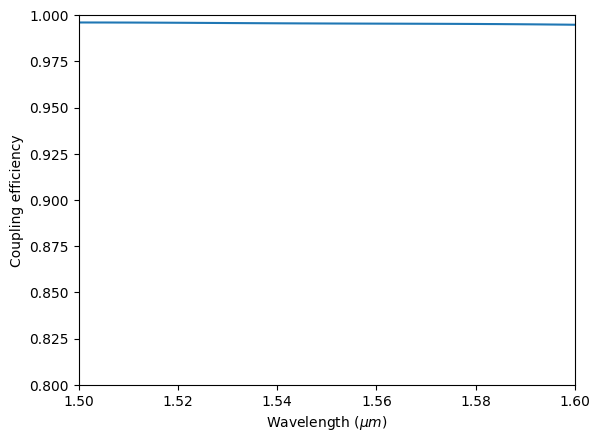

In [17]:
plot_convertion_efficiency(sim_data_2)

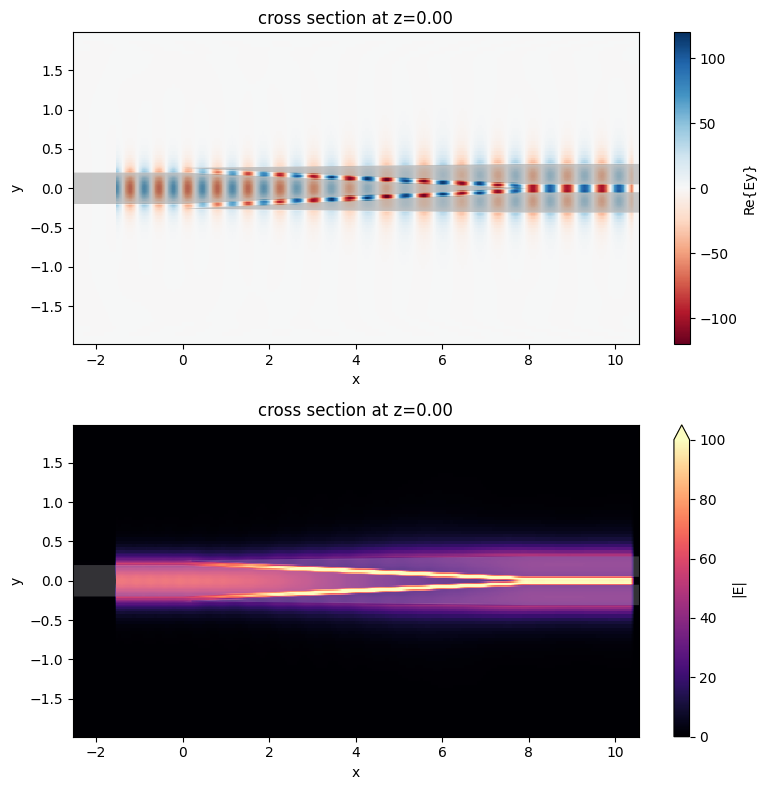

In [18]:
plot_field(sim_data_2)

## Design 3 

The last design is based on asymmetric linear taper as introduced in `Ning-Ning Feng, Rong Sun, Lionel C. Kimerling, and Jurgen Michel, "Lossless strip-to-slot waveguide transformer," Opt. Lett. 32, 1250-1252 (2007)`[DOI: 10.1364/OL.32.001250](https://doi.org/10.1364/OL.32.001250). This design is the most straightforward while the footprint is relatively large and it contains small features that are difficult to fabricate. In the ideal case as simulated here, the coupling efficiency can also be close to 100%.

Again, the process of setting up the simulation is similar to the previous two. Note that for this device, we can only use `symmetry=(0,0,1)` since there is no symmetry in the $y$ direction.

<img src="img/strip_to_slot_3.png" width="400" alt="Schematic of the third strip to slot converter design">

In [19]:
L = 20  # length of the converter region

vertices = [
    (-buffer, w_strip / 2),
    (0, w_strip / 2),
    (L, w_slot / 2),
    (L + buffer, w_slot / 2),
    (L + buffer, g / 2),
    (L, g / 2),
    (0, -w_strip / 2),
    (-buffer, -w_strip / 2),
]

converter_top = td.Structure(
    geometry=td.PolySlab(vertices=vertices, axis=2, slab_bounds=(-h_si / 2, h_si / 2)), medium=si
)

vertices = [
    (0, -w_strip / 2 - g),
    (L, -g / 2),
    (L + buffer, -g / 2),
    (L + buffer, -w_slot / 2),
    (L, -w_slot / 2),
]

converter_bottom = td.Structure(
    geometry=td.PolySlab(vertices=vertices, axis=2, slab_bounds=(-h_si / 2, h_si / 2)), medium=si
)

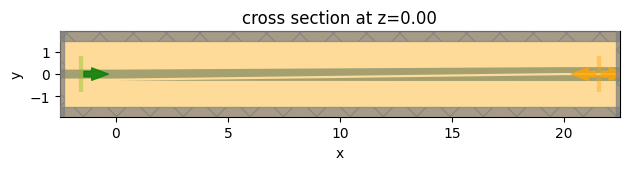

In [20]:
mode_monitor = mode_monitor.copy(update={"center": (L + lda0, 0, 0)})

Lx = L + 3 * lda0  # simulation domain size in x direction
sim_size = (Lx, Ly, Lz)

# construct simulation
sim_3 = td.Simulation(
    center=(L / 2, 0, 0),
    size=sim_size,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=30, wavelength=lda0),
    structures=[converter_top, converter_bottom],
    sources=[mode_source],
    monitors=[mode_monitor, field_monitor],
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
    medium=sio2,
    symmetry=(0, 0, 1),
)

sim_3.plot(z=0)
plt.show()

In [21]:
sim_data_3 = web.run(
    simulation=sim_3, task_name="strip_to_slot_converter_3", path="data/simulation_data.hdf5"
)

13:04:40 Eastern Standard Time Created task 'strip_to_slot_converter_3' with    
                               task_id                                          
                               'fdve-31e7b7e5-a072-42fe-a0ea-16e6a690197e' and  
                               task_type 'FDTD'.

                               View task using web UI at                        
                               ]8;id=565867;https://tidy3d.simulation.cloud/workbench?taskId=fdve-31e7b7e5-a072-42fe-a0ea-16e6a690197e\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=791631;https://tidy3d.simulation.cloud/workbench?taskId=fdve-31e7b7e5-a072-42fe-a0ea-16e6a690197e\taskId]8;;\
                               ]8;id=565867;https://tidy3d.simulation.cloud/workbench?taskId=fdve-31e7b7e5-a072-42fe-a0ea-16e6a690197e\=]8;;\]8;id=410817;https://tidy3d.simulation.cloud/workbench?taskId=fdve-31e7b7e5-a072-42fe-a0ea-16e6a690197e\fdve]8;;\]8;id=565867;https://tidy3d.simulation.cloud/workbench?taskId=fdve-31e7b7e5-a072-42fe-a0ea-16e6a690197e\-31e7b7e5-a072-42fe-a0ea-16e6a690197e']8;;\.

Output()

13:04:41 Eastern Standard Time status = queued

Output()

13:04:47 Eastern Standard Time status = preprocess

13:04:50 Eastern Standard Time Maximum FlexCredit cost: 0.166. Use              
                               'web.real_cost(task_id)' to get the billed       
                               FlexCredit cost after a simulation run.

                               starting up solver

                               running solver

                               To cancel the simulation, use                    
                               'web.abort(task_id)' or 'web.delete(task_id)' or 
                               abort/delete the task in the web UI. Terminating 
                               the Python script will not stop the job running  
                               on the cloud.

Output()

13:05:53 Eastern Standard Time early shutoff detected at 56%, exiting.

13:05:54 Eastern Standard Time status = postprocess

Output()

13:06:20 Eastern Standard Time status = success

                               View simulation result at                        
                               ]8;id=819353;https://tidy3d.simulation.cloud/workbench?taskId=fdve-31e7b7e5-a072-42fe-a0ea-16e6a690197e\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=562975;https://tidy3d.simulation.cloud/workbench?taskId=fdve-31e7b7e5-a072-42fe-a0ea-16e6a690197e\taskId]8;;\
                               ]8;id=819353;https://tidy3d.simulation.cloud/workbench?taskId=fdve-31e7b7e5-a072-42fe-a0ea-16e6a690197e\=]8;;\]8;id=176112;https://tidy3d.simulation.cloud/workbench?taskId=fdve-31e7b7e5-a072-42fe-a0ea-16e6a690197e\fdve]8;;\]8;id=819353;https://tidy3d.simulation.cloud/workbench?taskId=fdve-31e7b7e5-a072-42fe-a0ea-16e6a690197e\-31e7b7e5-a072-42fe-a0ea-16e6a690197e']8;;\.

Output()

13:06:22 Eastern Standard Time loading simulation from data/simulation_data.hdf5

The convertion efficiency is also close to 100%.

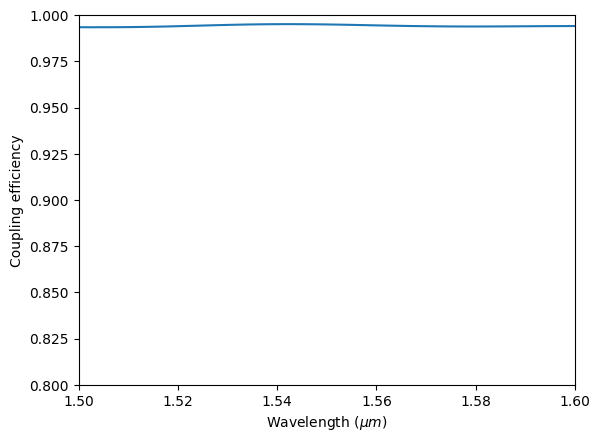

In [22]:
plot_convertion_efficiency(sim_data_3)

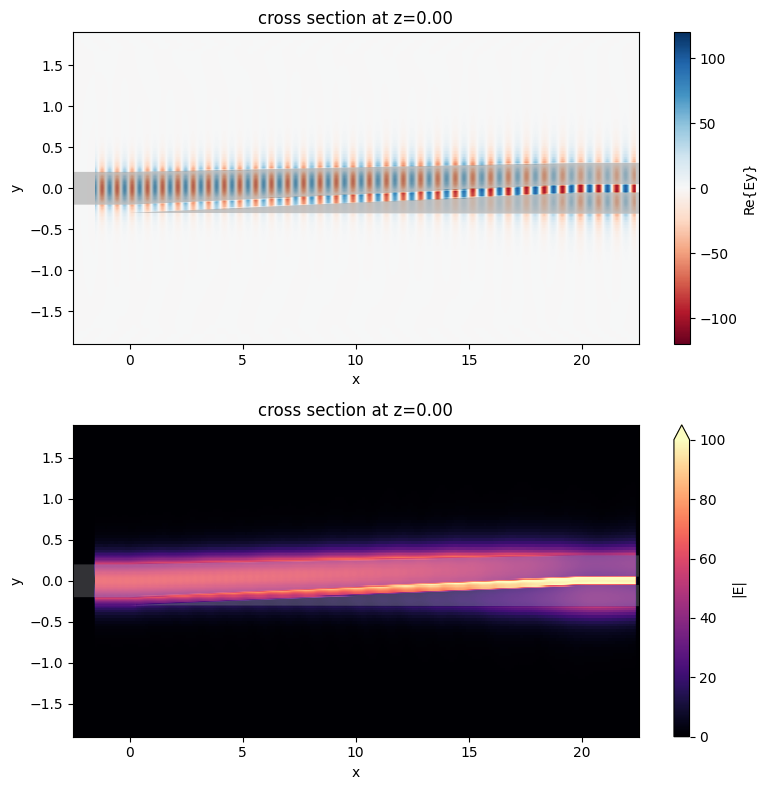

In [23]:
plot_field(sim_data_3)

## Closing Remark 

Different designs of the converters have their advantages and disadvantages. The choice of the design should be based on fabrication capability, constraints on device footprint, and the required coupling efficiency. In this notebook, we only simulated the ideal designs. To be more practical, simulations that consider the fabrication constraints need to be performed. As introduced in the referenced papers, the pointy tips of the tapers will have a finite width due to the finite fabrication resolution. Simulations with more realistic device geometry will be extremely useful for design and testing.

In addition, the design parameters used in this notebook are optimized for the specific waveguide widths, thickness, and materials. For a different plateform, the parameters need to be re-optmized, which can be done using the adjoint method as provided in Tidy3D's adjoint plugin. Users follow a similar procedure as introduced in the [tutorial](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin5BoundaryGradients/) of optimizing a waveguide taper.